In [222]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TFGPT2ForSequenceClassification, GPT2Config
from transformers import TFTrainingArguments, TFTrainer

In [223]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = 'intents.json'

intents = load_json_file(filename)

In [224]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

,Pattern,Tag


In [225]:
def extract_json_info(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [226]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 405 rows and 2 columns


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [228]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 38 classes


In [229]:
df.isnull().sum()

Pattern    0
Tag        0
dtype: int64

In [230]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

C:\Users\yatch\AppData\Local\Temp\ipykernel_18892\1755447801.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)


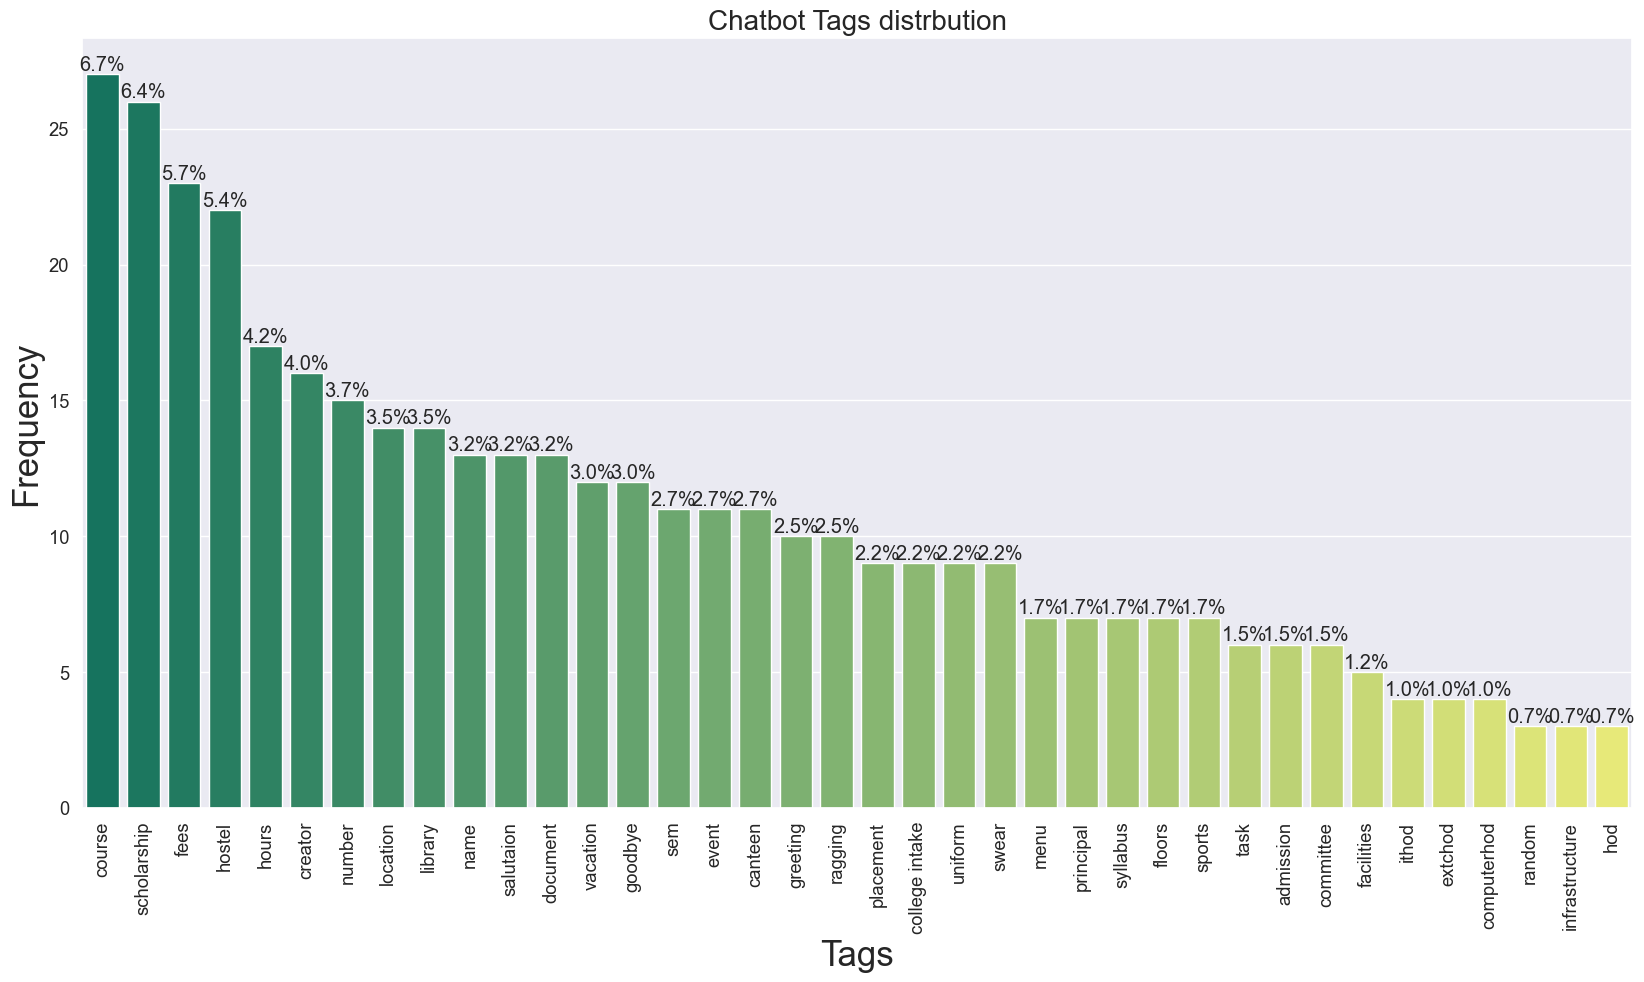

In [231]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [232]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


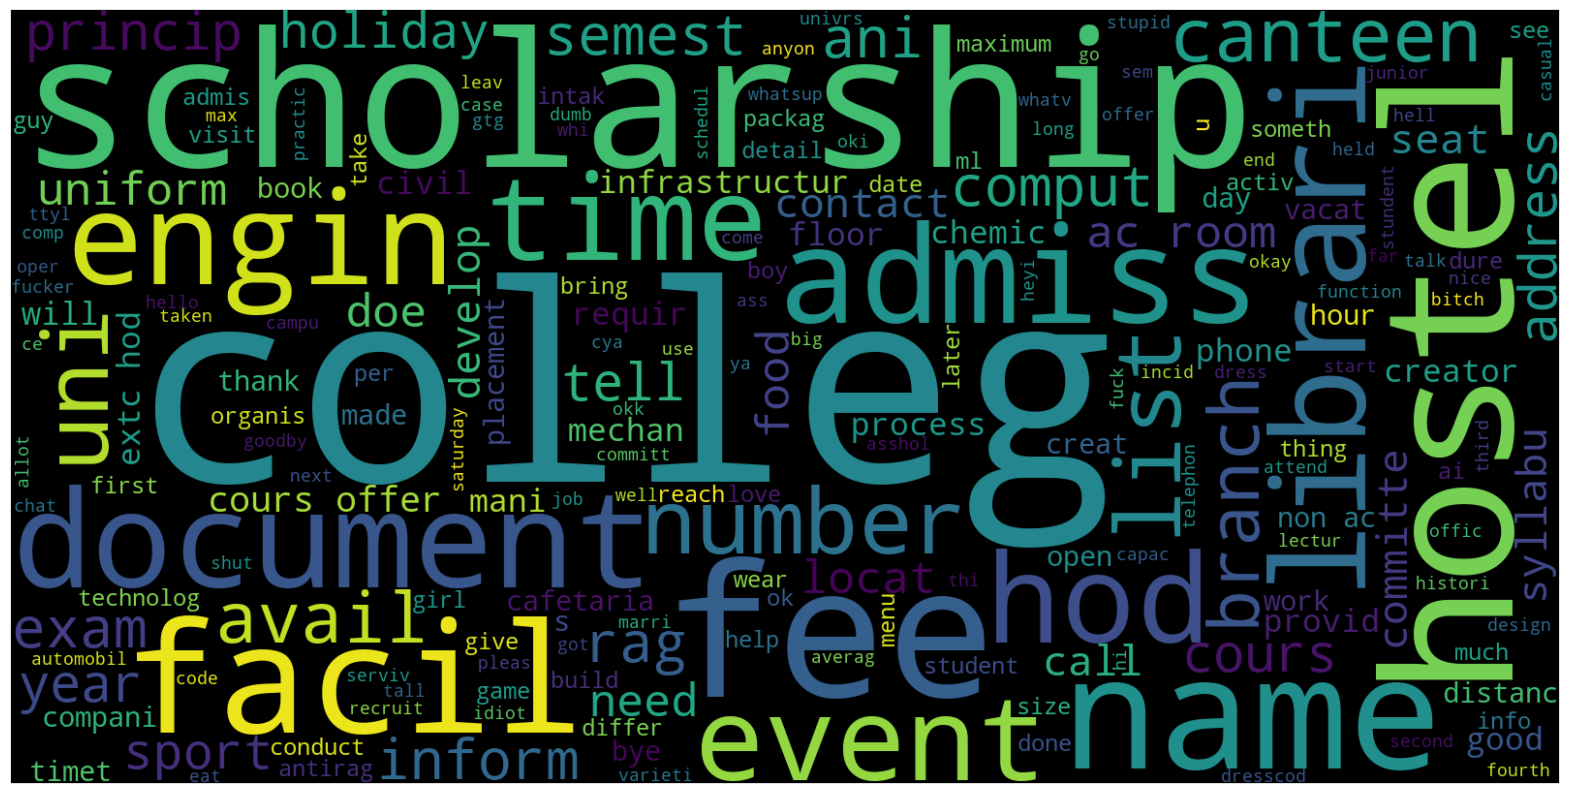

In [233]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

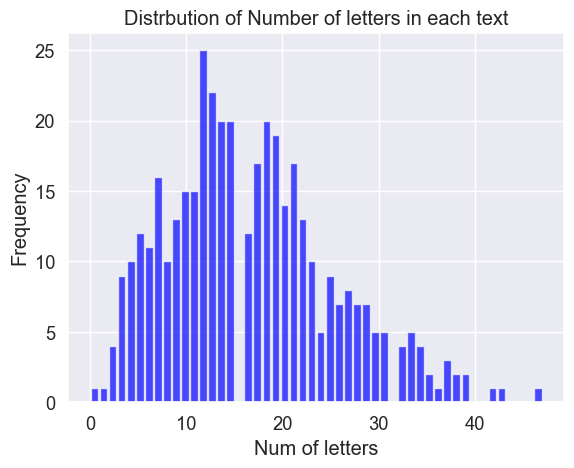

In [234]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='blue',bins=50, alpha=0.7, rwidth=0.85)
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

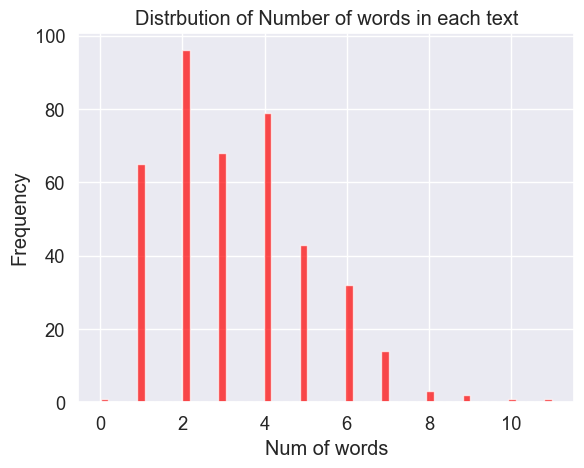

In [235]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='red',bins=50, alpha=0.7, rwidth=0.85)
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\yatch\AppData\Local\Temp\ipykernel_18892\3841709485.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color='red')


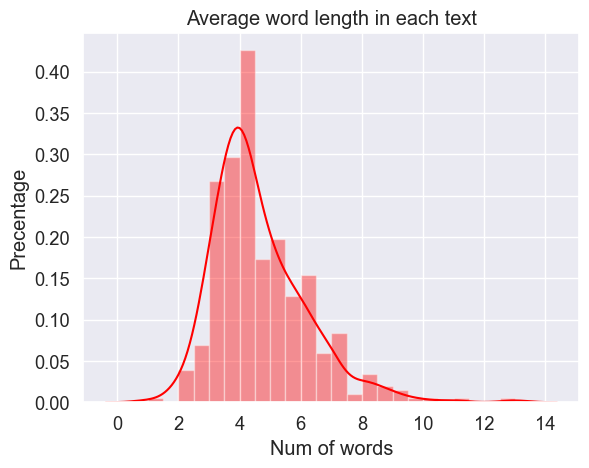

In [236]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [237]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'how', 'are', 'you', 'is']

In [238]:
print(f"dataset contains {len(corpus)} words")

dataset contains 1345 words


In [239]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'is': 75,
 'colleg': 71,
 'what': 59,
 'the': 46,
 'you': 35,
 'of': 33,
 'in': 29,
 'for': 26,
 'scholarship': 26,
 'are': 25}

In [240]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

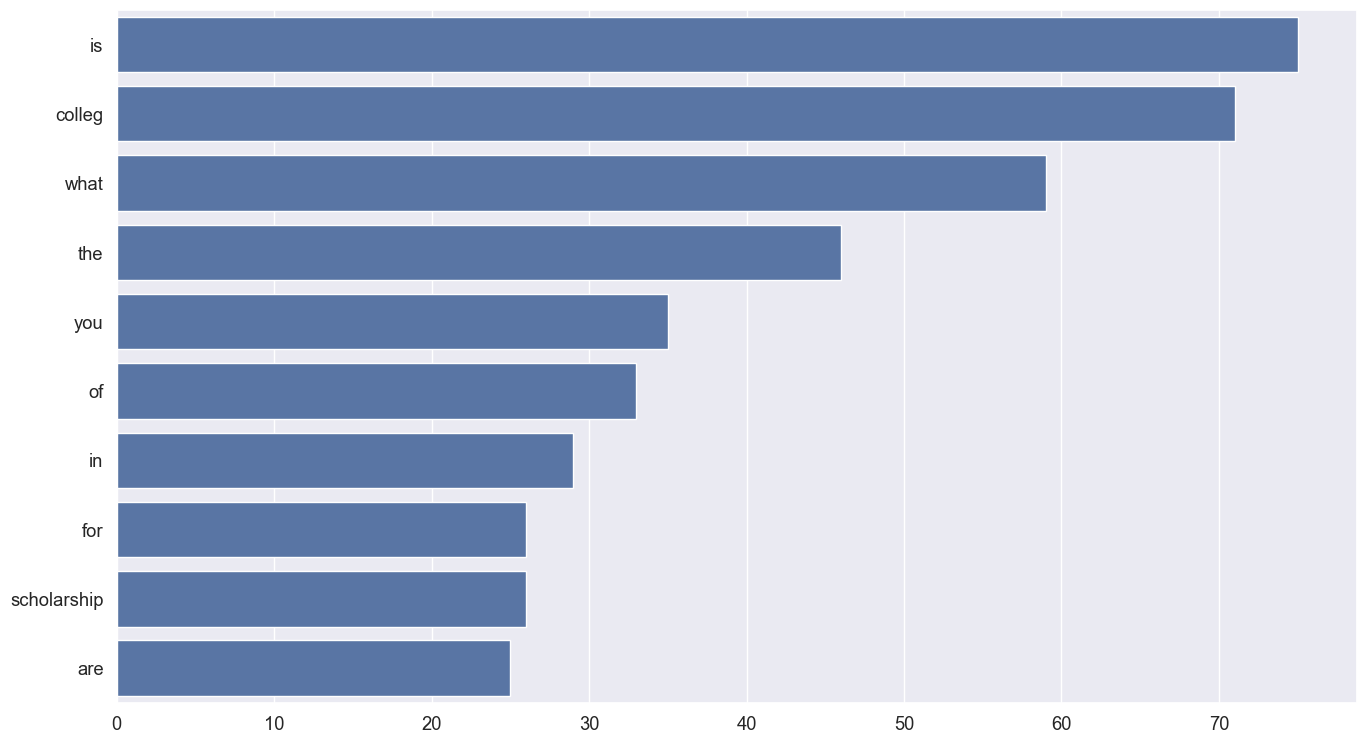

In [241]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

In [242]:
labels = df['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [243]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [244]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod'}

In [245]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37}

In [246]:
df['labels'] = df['Tag'].map(lambda x: label2id[x.strip()])
df.head()

,Pattern,Tag,labels
0,hi,greeting,0
1,how are you,greeting,0
2,is anyon there,greeting,0
3,hello,greeting,0
4,good day,greeting,0


In [247]:
X = list(df['Pattern'])
X[:5]

['hi', 'how are you', 'is anyon there', 'hello', 'good day']

In [248]:
y = list(df['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [249]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.2,random_state = 42)

In [250]:
model_name = "gpt2"
max_len = 256

tokenizer = GPT2Tokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

model = TFGPT2ForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

All PyTorch model weights were used when initializing TFGPT2ForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [251]:
tokenizer.pad_token = tokenizer.eos_token
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [252]:
full_data = tokenizer(X, truncation=True, padding=True)

In [253]:
def convert_to_tf_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

train_dataset = convert_to_tf_dataset(train_encoding, y_train)
test_dataset = convert_to_tf_dataset(test_encoding, y_test)

In [255]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Apply padding
# Apply padding
train_inputs = []
train_masks = []
for item in train_dataset_unbatched:
    input_ids = item[0]['input_ids']
    attention_mask = item[0]['attention_mask']
    
    # Ensure input_ids and attention_mask are lists
    if not isinstance(input_ids, list):
        input_ids = [input_ids]
    if not isinstance(attention_mask, list):
        attention_mask = [attention_mask]
    
    train_inputs.append(pad_sequences(input_ids, maxlen=256, truncating='post', padding='post'))
    train_masks.append(pad_sequences(attention_mask, maxlen=256, truncating='post', padding='post'))

# Convert lists to tf.data.Dataset
train_inputs_dataset = tf.data.Dataset.from_tensor_slices(train_inputs)
train_masks_dataset = tf.data.Dataset.from_tensor_slices(train_masks)

# Zip the datasets together
train_dataset_padded = tf.data.Dataset.zip((train_inputs_dataset, train_masks_dataset))

# Batch the dataset
train_dataset_padded = train_dataset_padded.batch(32)

In [256]:
# Apply padding
# Apply padding
test_inputs = []
test_masks = []
for item in test_dataset_unbatched:
    input_ids = item[0]['input_ids']
    attention_mask = item[0]['attention_mask']
    
    # Ensure input_ids and attention_mask are lists
    if not isinstance(input_ids, list):
        input_ids = [input_ids]
    if not isinstance(attention_mask, list):
        attention_mask = [attention_mask]
    
    test_inputs.append(pad_sequences(input_ids, maxlen=256, truncating='post', padding='post'))
    test_masks.append(pad_sequences(attention_mask, maxlen=256, truncating='post', padding='post'))

# Convert lists to tf.data.Dataset
test_inputs_dataset = tf.data.Dataset.from_tensor_slices(test_inputs)
test_masks_dataset = tf.data.Dataset.from_tensor_slices(test_masks)

# Zip the datasets together
test_dataset_padded = tf.data.Dataset.zip((test_inputs_dataset, test_masks_dataset))

# Batch the dataset
test_dataset_padded = test_dataset_padded.batch(32)

In [ ]:
def reshape_attention_mask(input_ids, attention_mask):
    attention_mask = tf.reshape(attention_mask, (tf.shape(attention_mask)[0], 1, 1, tf.shape(attention_mask)[1]))
    return input_ids, attention_mask

# Apply the function to your datasets
train_dataset_padded = train_dataset_padded.map(reshape_attention_mask)

test_dataset_padded = test_dataset_padded.map(reshape_attention_mask)

In [257]:
def compute_metrics(true_labels, predictions):
    preds = predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='macro')
    acc = accuracy_score(true_labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [258]:
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy(name="accuracy")]
)

In [260]:
callbacks = [
    ModelCheckpoint(filepath='./results/best_model', save_best_only=True, monitor='val_loss', save_format='tf'),
    EarlyStopping(monitor='val_loss', patience=3),
    TensorBoard(log_dir='./multi-class-logs')
]

history = model.fit(
    train_dataset_padded,  # Ensure dataset is batched
    validation_data=test_dataset_padded,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


3/3 [==============================] - ETA: 0s - loss: 3.8577 - accuracy: 0.0054      INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 608s 221s/step - loss: 3.8577 - accuracy: 0.0054 - val_loss: 2.8846 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2.5213 - accuracy: 0.2362  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 614s 231s/step - loss: 2.5213 - accuracy: 0.2362 - val_loss: 1.4843 - val_accuracy: 0.8516
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.1821 - accuracy: 0.8887  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 499s 164s/step - loss: 1.1821 - accuracy: 0.8887 - val_loss: 0.6142 - val_accuracy: 0.9329
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.9489  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 452s 158s/step - loss: 0.4833 - accuracy: 0.9489 - val_loss: 0.4229 - val_accuracy: 0.9396
Epoch 5/100
3/3 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.9572  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 459s 163s/step - loss: 0.3472 - accuracy: 0.9572 - val_loss: 0.3610 - val_accuracy: 0.9414
Epoch 6/100
3/3 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.9599  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 489s 181s/step - loss: 0.2922 - accuracy: 0.9599 - val_loss: 0.3207 - val_accuracy: 0.9414
Epoch 7/100
3/3 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.9610  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 502s 168s/step - loss: 0.2603 - accuracy: 0.9610 - val_loss: 0.2884 - val_accuracy: 0.9448
Epoch 8/100
3/3 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9619  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 486s 185s/step - loss: 0.2405 - accuracy: 0.9619 - val_loss: 0.2563 - val_accuracy: 0.9529
Epoch 9/100
3/3 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9639  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 481s 174s/step - loss: 0.2187 - accuracy: 0.9639 - val_loss: 0.2246 - val_accuracy: 0.9609
Epoch 10/100
3/3 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9676  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 482s 179s/step - loss: 0.1970 - accuracy: 0.9676 - val_loss: 0.1967 - val_accuracy: 0.9677
Epoch 11/100
3/3 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9719  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 457s 174s/step - loss: 0.1841 - accuracy: 0.9719 - val_loss: 0.1740 - val_accuracy: 0.9729
Epoch 12/100
3/3 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9757  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 470s 171s/step - loss: 0.1653 - accuracy: 0.9757 - val_loss: 0.1564 - val_accuracy: 0.9768
Epoch 13/100
3/3 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9793  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 527s 185s/step - loss: 0.1487 - accuracy: 0.9793 - val_loss: 0.1426 - val_accuracy: 0.9796
Epoch 14/100
3/3 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9811  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 513s 197s/step - loss: 0.1372 - accuracy: 0.9811 - val_loss: 0.1316 - val_accuracy: 0.9817
Epoch 15/100
3/3 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9829  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 508s 183s/step - loss: 0.1259 - accuracy: 0.9829 - val_loss: 0.1223 - val_accuracy: 0.9838
Epoch 16/100
3/3 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9841  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 461s 172s/step - loss: 0.1154 - accuracy: 0.9841 - val_loss: 0.1142 - val_accuracy: 0.9847
Epoch 17/100
3/3 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9844  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 477s 181s/step - loss: 0.1040 - accuracy: 0.9844 - val_loss: 0.1070 - val_accuracy: 0.9862
Epoch 18/100
3/3 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9848  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 469s 170s/step - loss: 0.1026 - accuracy: 0.9848 - val_loss: 0.1001 - val_accuracy: 0.9865
Epoch 19/100
3/3 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9851  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 503s 183s/step - loss: 0.0916 - accuracy: 0.9851 - val_loss: 0.0932 - val_accuracy: 0.9867
Epoch 20/100
3/3 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9850  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 484s 184s/step - loss: 0.0851 - accuracy: 0.9850 - val_loss: 0.0862 - val_accuracy: 0.9868
Epoch 21/100
3/3 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9850  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 480s 172s/step - loss: 0.0770 - accuracy: 0.9850 - val_loss: 0.0790 - val_accuracy: 0.9870
Epoch 22/100
3/3 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9856  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 497s 184s/step - loss: 0.0717 - accuracy: 0.9856 - val_loss: 0.0712 - val_accuracy: 0.9871
Epoch 23/100
3/3 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9858  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 461s 167s/step - loss: 0.0612 - accuracy: 0.9858 - val_loss: 0.0630 - val_accuracy: 0.9878
Epoch 24/100
3/3 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9872  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 446s 171s/step - loss: 0.0575 - accuracy: 0.9872 - val_loss: 0.0551 - val_accuracy: 0.9888
Epoch 25/100
3/3 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9875  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 450s 168s/step - loss: 0.0523 - accuracy: 0.9875 - val_loss: 0.0483 - val_accuracy: 0.9901
Epoch 26/100
3/3 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9892  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 449s 166s/step - loss: 0.0462 - accuracy: 0.9892 - val_loss: 0.0427 - val_accuracy: 0.9917
Epoch 27/100
3/3 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9905  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 453s 173s/step - loss: 0.0424 - accuracy: 0.9905 - val_loss: 0.0381 - val_accuracy: 0.9929
Epoch 28/100
3/3 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9910  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 497s 181s/step - loss: 0.0400 - accuracy: 0.9910 - val_loss: 0.0338 - val_accuracy: 0.9943
Epoch 29/100
3/3 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.9915  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 480s 181s/step - loss: 0.0355 - accuracy: 0.9915 - val_loss: 0.0302 - val_accuracy: 0.9959
Epoch 30/100
3/3 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9925  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 482s 175s/step - loss: 0.0340 - accuracy: 0.9925 - val_loss: 0.0270 - val_accuracy: 0.9969
Epoch 31/100
3/3 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9941  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 464s 173s/step - loss: 0.0286 - accuracy: 0.9941 - val_loss: 0.0242 - val_accuracy: 0.9978
Epoch 32/100
3/3 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9952  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 437s 166s/step - loss: 0.0258 - accuracy: 0.9952 - val_loss: 0.0218 - val_accuracy: 0.9985
Epoch 33/100
3/3 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9951  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 439s 168s/step - loss: 0.0250 - accuracy: 0.9951 - val_loss: 0.0196 - val_accuracy: 0.9988
Epoch 34/100
3/3 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9956  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 470s 174s/step - loss: 0.0239 - accuracy: 0.9956 - val_loss: 0.0175 - val_accuracy: 0.9992
Epoch 35/100
3/3 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9971  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 449s 166s/step - loss: 0.0180 - accuracy: 0.9971 - val_loss: 0.0156 - val_accuracy: 0.9994
Epoch 36/100
3/3 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9971  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 553s 204s/step - loss: 0.0169 - accuracy: 0.9971 - val_loss: 0.0140 - val_accuracy: 0.9996
Epoch 37/100
3/3 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9976  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 475s 175s/step - loss: 0.0150 - accuracy: 0.9976 - val_loss: 0.0126 - val_accuracy: 0.9996
Epoch 38/100
3/3 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9973  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 474s 177s/step - loss: 0.0169 - accuracy: 0.9973 - val_loss: 0.0113 - val_accuracy: 0.9998
Epoch 39/100
3/3 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9982  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 464s 173s/step - loss: 0.0119 - accuracy: 0.9982 - val_loss: 0.0103 - val_accuracy: 0.9998
Epoch 40/100
3/3 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9980  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 449s 173s/step - loss: 0.0121 - accuracy: 0.9980 - val_loss: 0.0094 - val_accuracy: 0.9999
Epoch 41/100
3/3 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9977  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 484s 177s/step - loss: 0.0134 - accuracy: 0.9977 - val_loss: 0.0086 - val_accuracy: 0.9999
Epoch 42/100
3/3 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 465s 174s/step - loss: 0.0108 - accuracy: 0.9980 - val_loss: 0.0079 - val_accuracy: 0.9999
Epoch 43/100
3/3 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9984  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 446s 167s/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 44/100
3/3 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 476s 172s/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 45/100
3/3 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9986  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 514s 187s/step - loss: 0.0080 - accuracy: 0.9986 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 46/100
3/3 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9984  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 487s 178s/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 47/100
3/3 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9986  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 486s 175s/step - loss: 0.0080 - accuracy: 0.9986 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 48/100
3/3 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9990  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 448s 170s/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 49/100
3/3 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9985  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 459s 175s/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 50/100
3/3 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9986  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 455s 173s/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 51/100
3/3 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9985  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 480s 178s/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 52/100
3/3 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 476s 173s/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 53/100
3/3 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 462s 172s/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 54/100
3/3 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 460s 164s/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 55/100
3/3 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 464s 176s/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 56/100
3/3 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9985  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 460s 178s/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 57/100
3/3 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 458s 173s/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 58/100
3/3 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 467s 177s/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 59/100
3/3 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 449s 169s/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 60/100
3/3 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9990  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 427s 160s/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 61/100
3/3 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 467s 179s/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 62/100
3/3 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9990  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 468s 175s/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 63/100
3/3 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 496s 181s/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 64/100
3/3 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9990  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 470s 174s/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 65/100
3/3 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 483s 183s/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 66/100
3/3 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 498s 181s/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 67/100
3/3 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 433s 169s/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 68/100
3/3 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 441s 165s/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 69/100
3/3 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 434s 162s/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 70/100
3/3 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 462s 179s/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 71/100
3/3 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 443s 164s/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 72/100
3/3 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9993  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 454s 176s/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 73/100
3/3 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 484s 180s/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 74/100
3/3 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9991  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 437s 166s/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 75/100
3/3 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 453s 175s/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 76/100
3/3 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 460s 174s/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 77/100
3/3 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 426s 163s/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 78/100
3/3 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9994  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 482s 175s/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 79/100
3/3 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9993  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 446s 166s/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 80/100
3/3 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 469s 176s/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 81/100
3/3 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9987  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 452s 173s/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 82/100
3/3 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9993  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 447s 171s/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 83/100
3/3 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9991  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 452s 174s/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 84/100
3/3 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9990  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 439s 166s/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 85/100
3/3 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 481s 183s/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 86/100
3/3 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9992  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 440s 166s/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 87/100
3/3 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 447s 170s/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 88/100
3/3 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9989  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 473s 182s/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 89/100
3/3 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9990  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 456s 172s/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 90/100
3/3 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9993  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 479s 184s/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 91/100
3/3 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 473s 175s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 92/100
3/3 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9988  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 445s 173s/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 93/100
3/3 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 530s 204s/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 94/100
3/3 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9991  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 459s 170s/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 95/100
3/3 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9993  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 454s 175s/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 96/100
3/3 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 435s 167s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 97/100
3/3 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9990  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 476s 183s/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 98/100
3/3 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9991  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 468s 175s/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 99/100
3/3 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 459s 174s/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 100/100
3/3 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9991  INFO:tensorflow:Assets written to: ./results\best_model\assets


INFO:tensorflow:Assets written to: ./results\best_model\assets


3/3 [==============================] - 454s 177s/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0019 - val_accuracy: 1.0000


In [262]:
eval_results = model.evaluate(test_dataset_padded)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

11/11 [==============================] - 156s 14s/step - loss: 0.0019 - accuracy: 1.0000
Test Loss: 0.00194612389896065, Test Accuracy: 0.999975860118866


In [281]:
def predict_tf(text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="tf")
    
    # Get model predictions
    outputs = model(inputs)
    
    # Apply softmax to the logits output by the model
    probs = tf.nn.softmax(outputs.logits)
    
    # Get the predicted label index
    pred_label_idx = tf.argmax(probs, axis=1).numpy()[0][0]
    
    pred_label = model.config.id2label[pred_label_idx]

    return probs, pred_label_idx, pred_label

In [282]:
text = "Hello"
probs, pred_label_idx, pred_label = predict_tf(text)
print(probs, pred_label_idx, pred_label)

tf.Tensor(
[[[5.22948289e-03 7.03010619e-01 1.28413048e-02 1.74419687e-03
   7.77317723e-03 4.81116306e-03 1.11408234e-02 1.13719329e-02
   2.66796583e-03 9.95722227e-03 5.99931751e-04 6.77777780e-03
   1.20629673e-03 4.40042093e-03 7.48375850e-03 4.81225271e-03
   2.24814954e-04 7.76079623e-03 1.31681114e-02 5.04337810e-03
   6.11650012e-03 2.65734782e-03 7.93251966e-04 3.41591090e-02
   2.00400632e-02 1.28153265e-02 1.41058760e-02 7.29547581e-03
   2.10552476e-03 2.86639063e-03 1.53454638e-03 9.57987737e-03
   1.11588894e-03 6.96722977e-03 1.06725199e-02 3.28856073e-02
   1.20815262e-03 1.10558905e-02]]], shape=(1, 1, 38), dtype=float32) 0 greeting


In [284]:
model_path = "chatbot"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('chatbot\\tokenizer_config.json',
 'chatbot\\special_tokens_map.json',
 'chatbot\\vocab.json',
 'chatbot\\merges.txt',
 'chatbot\\added_tokens.json')

In [285]:
model_path = "chatbot"


model = TFGPT2ForSequenceClassification.from_pretrained(model_path)
tokenizer= GPT2Tokenizer.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

All the layers of TFGPT2ForSequenceClassification were initialized from the model checkpoint at chatbot.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2ForSequenceClassification for predictions without further training.


In [305]:
chatbot("Hello")

[{'label': 'goodbye', 'score': 0.7030106782913208}]

In [306]:
def chat(chatbot):
    
    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")
    
    text = input("User: ").strip().lower()
    
    while(text != 'quit'):

        score = chatbot(text)[0]['score']
        
        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue
        
        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])
        
        print(f"Chatbot: {response}\n\n")
            
        text = input("User: ").strip().lower()

In [308]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat




KeyError: 77